In [2]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import copy
import operator
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from scipy.signal import find_peaks
import json
import os
import warnings
import math
import pandas as pd
from sklearn.decomposition import PCA

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
def read_jsons(folder):
    jsons = [json for json in os.listdir(folder) if json.endswith(".json")]
    
    return jsons

In [4]:
def data_points(jsons, json_folder_dir):
    data_points = []
    
    for i in range(0, len(jsons)):
        data_points.append([])
        with open((json_folder_dir + jsons[i])) as f:
            data = json.load(f)
        
        n_people = len(data['people'])
    
        for j in range(0, n_people):
            data_points[i].append([])
            datas = data['people'][j]['pose_keypoints_2d']
        
            for k in range(0, len(datas)):
                data_points[i][j].append(datas[k])
                
    return data_points 

In [5]:
def data_classification(data):
    body_label = {0:"Nose", 1:"Neck", 2:"RShoulder", 3:"RElbow", 4:"RWrist", 5:"LShoulder", 6:"LElbow", 7:"LWrist", 8:"MidHip", 9:"RHip", 10:"RKnee", 11:"RAnkle", 12:"LHip", 13:"LKnee",14:"LAnkle", 15:"REye", 16:"LEye", 17:"REar", 18:"LEar", 19:"LBigToe", 20:"LSmallToe", 21:"LHeel", 22:"RBigToe", 23:"RSmallToe", 24:"RHeel"}
    parts = {}
    people = {}
    
    for person in range(0, len(data)):
        points = data[person]
        for i in range(0, len(points)):
            parts[body_label[i]] = points[i]
        
        people[person] = parts
        parts = {}
        
    return people

In [6]:
def organise_data(data, number):
    total = len(data)
    people_body_point = {}
    
    for i in range(0, total):
        people = len(data[i])
        frame_points = {}
        id_number = 0
        if people != 0:
            for j in range(0, people):
                points = data[i][j]
                n_points = len(points)
                body_points = []
                data_certainty = 0
                for k in range(0, n_points - 1, 3):
                    body_points.append((points[0 + k], points[1 + k]))
                    data_certainty += points[2 + k]
                    
                
                data_certainty = data_certainty / number
                
                if data_certainty >= 0.5:
                    frame_points[id_number] = body_points
                    id_number += 1
                
            organised = data_classification(frame_points)
            people_body_point[i] = organised
                
    return people_body_point

In [7]:
def organiseAllPoints(data):
    new_data = {}
    
    keys = ['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel']
    
    # Initialisation
    for i in range(len(keys)):
        
        new_data[keys[i]] = []
       
    for keys in data:
        for Lkeys in data[keys]:
            coordinate = new_data[Lkeys]
            
            points = data[keys][Lkeys]
            
            coordinate.append(points)
                        
            new_data[Lkeys] = coordinate            
    
    return new_data

In [8]:
def data_pca(data):
    
    exercise = {}
    
    for frame in data:
        body_point = []

        for part in data[frame]:
            body_point += data[frame][part]

        exercise[frame] = body_point
        
    return exercise

In [9]:
def returnNumber(superFolder, subFolder):
    number = 25
    
    if superFolder == 'Star_Jumps':
        if subFolder == 'Starjump10':
            number = 26
        if subFolder == 'Starjump7' or 'Starjump8' or 'Starjump9':
            number = 20
        
    if superFolder == 'Squats':
        if subFolder == 'Squats_21' or subFolder == 'Squats_22':
            number = 13
            
        if subFolder == 'Squats_23':
            number = 10
            
    if superFolder == 'Biceps':
        if subFolder == 'Bicep8' or subFolder == 'Bicep9' or subFolder == 'Bicep10':
            number = 20
            
        if subFolder == 'Bicep12':
            number = 13

        if subFolder == 'Bicep13' or subFolder == 'Bicep15':
            number = 16
        
        if subFolder == 'Bicep14':
             number = 18
            
        
    if superFolder == 'Chests':
        if subFolder == 'Chest6' or subFolder == 'Chest7' or subFolder == 'Chest8':
            number = 20
            
        if subFolder == 'Chest11' or subFolder == 'Chest12':
            number = 15

        if subFolder == 'Chest13':
            number = 14
            
    if superFolder == 'Punches':
        number = 20
        
        if subFolder == 'Punches12':
            number = 14
            
        if subFolder == 'Punches7' or subFolder == 'Punches8' or subFolder == 'Punches9':
            number = 11
        
    return number

In [10]:
def reformat(data):
    
    exercise = {}
    
    for i in data:
        for j in data[i]:
            exercise[i] = data[i][j]
            
    return exercise

In [11]:
def rescale(data):
    
    allPoints = organiseAllPoints(data)
        
    new_data = {}
    
    for keys in allPoints:
#         ini = {}
#         ini['x'] = []
#         ini['y'] = []
        
        new_data[keys] = []
        
    fit_points = []
    first = True
    
    for keys in allPoints:
        if first:
            fit_points = allPoints[keys]
            first = False
        else:
            fit_points + allPoints[keys]
                
    for keys in allPoints:
        points = scaler.transform(allPoints[keys])
        
#         x = points[:, 0]
#         y = points[:, 1]
#         x_mean = np.mean(x)
#         x_std = np.std(x)
#         y_mean = np.mean(y)
#         y_std = np.std(y)
        
#         X = [x_mean, x_std]
#         Y = [y_mean, y_std]
        
#         new_data[keys]['x'] = X
#         new_data[keys]['y'] = Y

        new_data[keys] = points
        
    return new_data

In [12]:
def neededParts(Sports, parts):
    
    parts_needed = []
    
    if Sports is 'Squats':
        parts_needed = ['RShoulder', 'LShoulder', 'LHip', 'MidHip', 'RHip']
    
    if Sports is 'Biceps':
        parts_needed = ['LWrist', 'RWrist']
        
    if Sports is 'Chests':
        parts_needed = ['LWrist', 'RWrist', 'LElbow', 'RElbow']
        
    if Sports is 'Punches':
        parts_needed = ['LWrist', 'RWrist', 'LElbow', 'RElbow']
         
    if Sports is 'Star_Jumps':
        parts_needed = ['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel']
        
        
    needed = {}
    
    for frame in parts:
        point = {}
        for part in parts[frame]:
            if part in parts_needed:
                point[part] = parts[frame][part]
                needed[frame]= point

    return needed, len(parts_needed)

In [13]:
def read_folders(superFolder):
    subFolders = next(os.walk('Sports_Skeleton/' + superFolder + '/.'))[1]
    print(subFolders)
    
    keyStart = 0
    
    total = {}
    
    first = True
    
    for i in range(len(subFolders)):
        json_folder = 'Sports_Skeleton/' + superFolder + '/' + subFolders[i]
        
        number = returnNumber(superFolder, subFolders[i]) 
            
        json_folder_slash = json_folder + '/'
        
        jsons = read_jsons(json_folder)
        
        data_points1 = data_points(jsons, json_folder_slash)
        
        part_points = organise_data(data_points1, number)
                
        reformat_points = reformat(part_points)
        
        parts, length = neededParts(superFolder, reformat_points)
        
        rescale_points = data_pca(parts)
        
        total[subFolders[i]] = rescale_points
                                
    return total, length

In [14]:
def rescaleIndividually(data):
    
    modified = copy.deepcopy(data)
    
    for keys in data:
        for parts in data[keys]:
            x = []
            y = []
            
            X = []
            Y = []
            
            for i in range(len(data[keys][parts])):
                
                X.append(data[keys][parts][i][0])
                Y.append(data[keys][parts][i][1])
                
                if data[keys][parts][i][0] != 0:
                    x.append(data[keys][parts][i][0])
                    
                if data[keys][parts][i][1] != 0:
                    y.append(data[keys][parts][i][1])
            
            if len(x) != 0:
            
                x_np = np.array(x).reshape(-1, 1)
                y_np = np.array(y).reshape(-1, 1)

                X_np = np.array(X).reshape(-1, 1)
                Y_np = np.array(Y).reshape(-1, 1)


                x_scaler = MinMaxScaler(feature_range=(-10, 10)).fit(x_np)
                y_scaler = MinMaxScaler(feature_range=(-10, 10)).fit(y_np)

                X_np = x_scaler.transform(X_np)
                Y_np = y_scaler.transform(Y_np)

                X_np = np.concatenate(X_np)
                Y_np = np.concatenate(Y_np)

                for i in range(len(data[keys][parts])):
                    rescaled_point = [X_np[i], Y_np[i]]
                    modified[keys][parts][i] = rescaled_point
                
    
    return modified

In [15]:
def checkXDirection(data):
    
    total = 0
    division = 0

    for part in data:
        x = []
        for i in range(len(data[part])):
            x.append(data[part][i][0])
        
        total += len(np.where(np.diff(np.signbit(x)))[0])
        division += 1
    
    return total / (division * 2)

In [16]:
def reject_outliers(data, m= 2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [108]:
def pcaAnalysis(data, number):
    
    first = True
    
    for file in data:
        
        df = pd.DataFrame(data = data[file]).transpose()
        
        features = []
        
        for i in range(number):
            features.append(i)
            
        frame = []
        
        for i in range(len(data[file])):
            frame.append(i)
            
        x = df.loc[:, features].values
        x = StandardScaler().fit_transform(x)
        
        pca = PCA(n_components = 2)
        
        principalComponents = pca.fit_transform(x)
        
        principalDf = pd.DataFrame(data = principalComponents, columns = ['1', '2'])
        
        thresholded = []
        thresholded2 = []
        new_frame = []
        new_frame2 = []
        thresholded3 = []
        new_frame3 = []
        
        for i in range(len(frame)):
            if principalDf.loc[i, '1'] < 30:
                thresholded.append(principalDf.loc[i, '1'])
                
            if principalDf.loc[i, '2'] < 30:
                thresholded2.append(principalDf.loc[i, '2'])
                
                
        thresholded_np = np.array(thresholded)
        thresholded2_np = np.array(thresholded2)
        thresholded3_np = np.array(thresholded3)
        
        thresholded_np = reject_outliers(thresholded_np)
        
        for i in range(len(thresholded_np)):
            new_frame.append(i)
        
        correlation1 = thresholded_np.reshape(-1,1)
        correlation1_org = np.concatenate(correlation1)
        new_frame_shape = np.array(new_frame).reshape(-1, 1)

        model = make_pipeline(PolynomialFeatures(10), Ridge())
        model.fit(new_frame_shape, correlation1)
        y_plot = model.predict(new_frame_shape)
        
        peaks, _ = find_peaks(correlation1_org, height = np.concatenate(y_plot), distance=30)
        
        plt.figure(1, figsize=(15,10))
        
        
        plt.plot(correlation1_org)
        plt.title("PCA against time: Jumping Jacks", fontsize = 15)
        plt.xlabel("Time", fontsize = 15)
        plt.ylabel("PCA value", fontsize = 15)
        plt.xticks(size = 15)
        plt.yticks(size = 15)
        plt.plot(y_plot)
        plt.plot(peaks, correlation1_org[peaks], "x", markersize = 15)
        if first:
            plt.savefig("StarJump_PCA.png")
            first = False
            
        plt.show()


        print(len(peaks))
        
        
        
#     return peaks

In [18]:
squats0, length0 = read_folders('Squats')
arms0, length1 = read_folders('Biceps')
starJump0, length2 = read_folders('Star_Jumps')
chest0, length3 = read_folders('Chests')
punch0, length4 = read_folders('Punches')

['Squats_12', 'Squats_13', 'Squats_14', 'Squats_15', 'Squats_16', 'Squats_17', 'Squats_18', 'Squats_19', 'Squats_21', 'Squats_22', 'Squats_23', 'Squats_4', 'Squats_5']
['Bicep1', 'Bicep10', 'Bicep11', 'Bicep12', 'Bicep13', 'Bicep14', 'Bicep15', 'Bicep3', 'Bicep4', 'Bicep5', 'Bicep6', 'Bicep7', 'Bicep8', 'Bicep9']
['Star_Jump1', 'Star_Jump10', 'Star_Jump11', 'Star_Jump12', 'Star_Jump13', 'Star_Jump14', 'Star_Jump2', 'Star_Jump3', 'Star_Jump4', 'Star_Jump5', 'Star_Jump6', 'Star_Jump7', 'Star_Jump8', 'Star_Jump9']
['Chest1', 'Chest10', 'Chest11', 'Chest12', 'Chest13', 'Chest2', 'Chest3', 'Chest4', 'Chest5', 'Chest6', 'Chest7', 'Chest8', 'Chest9']
['Punches1', 'Punches10', 'Punches11', 'Punches12', 'Punches13', 'Punches2', 'Punches3', 'Punches4', 'Punches5', 'Punches6', 'Punches7', 'Punches8', 'Punches9']


In [19]:
# pprint(chest0)

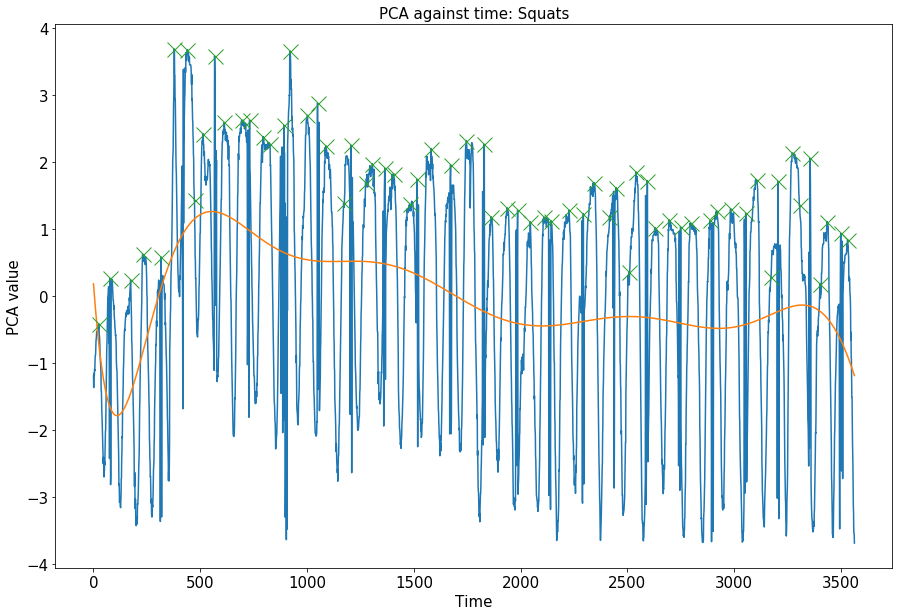

64


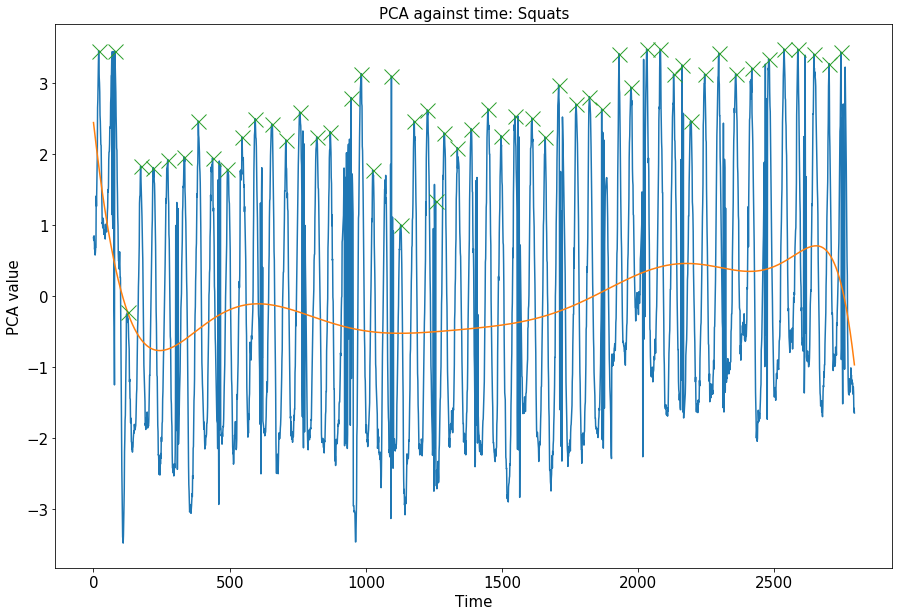

54


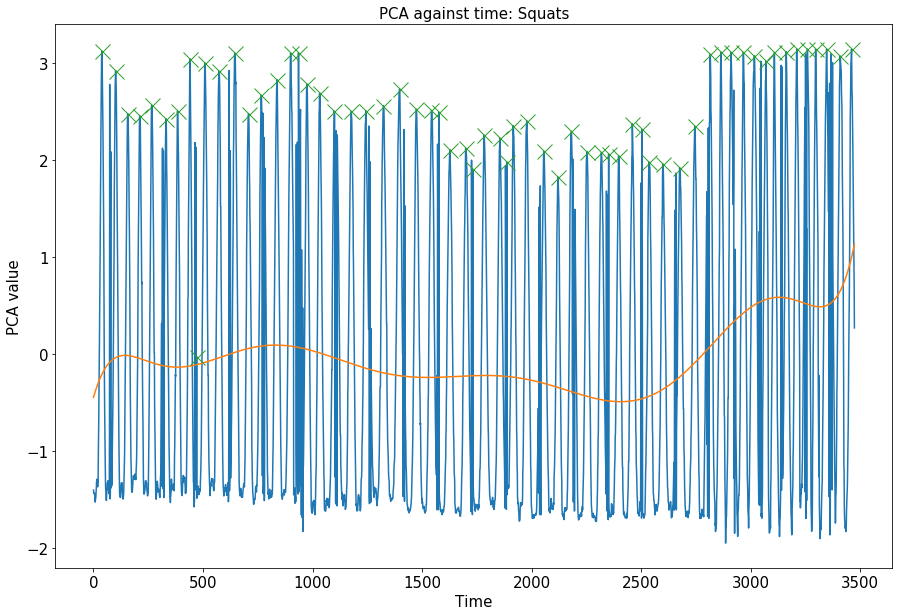

62


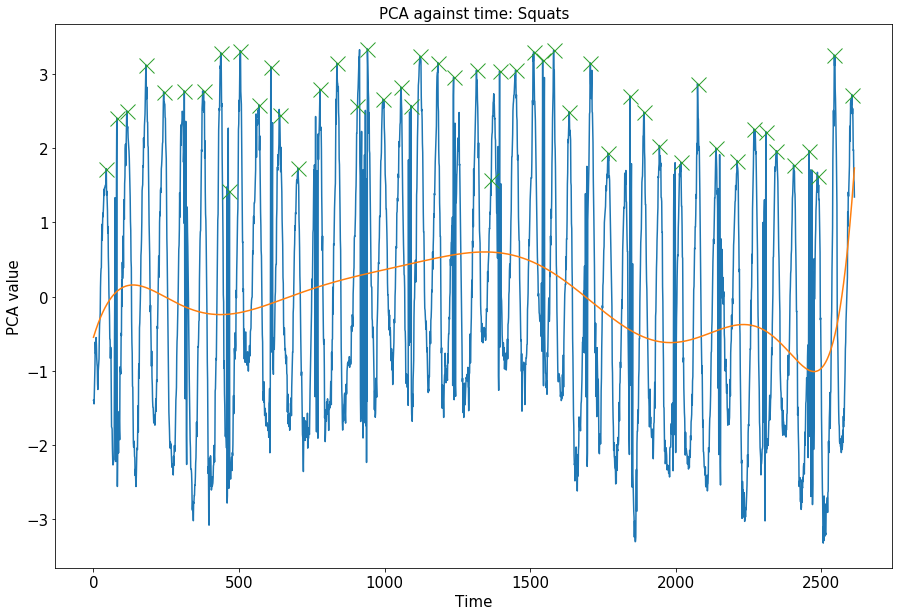

49


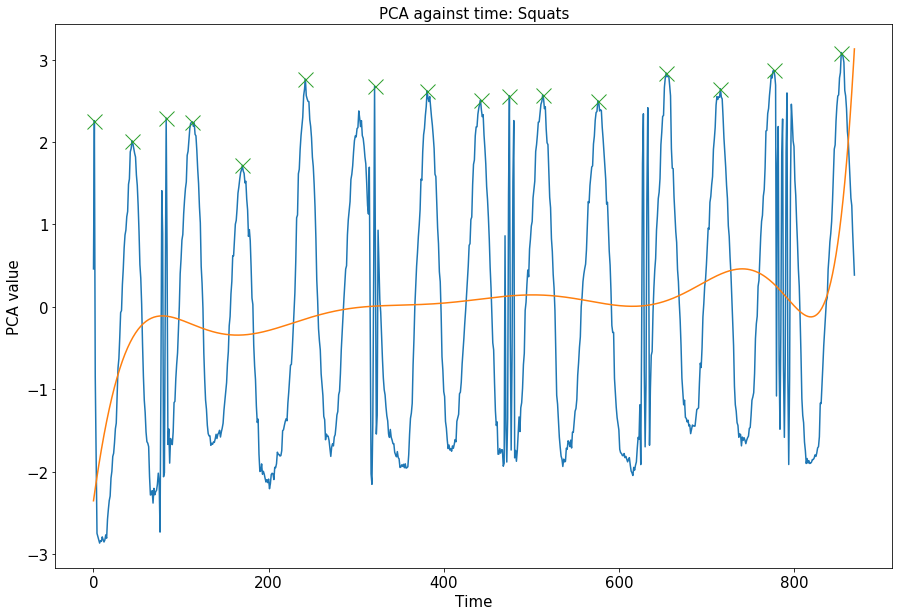

16


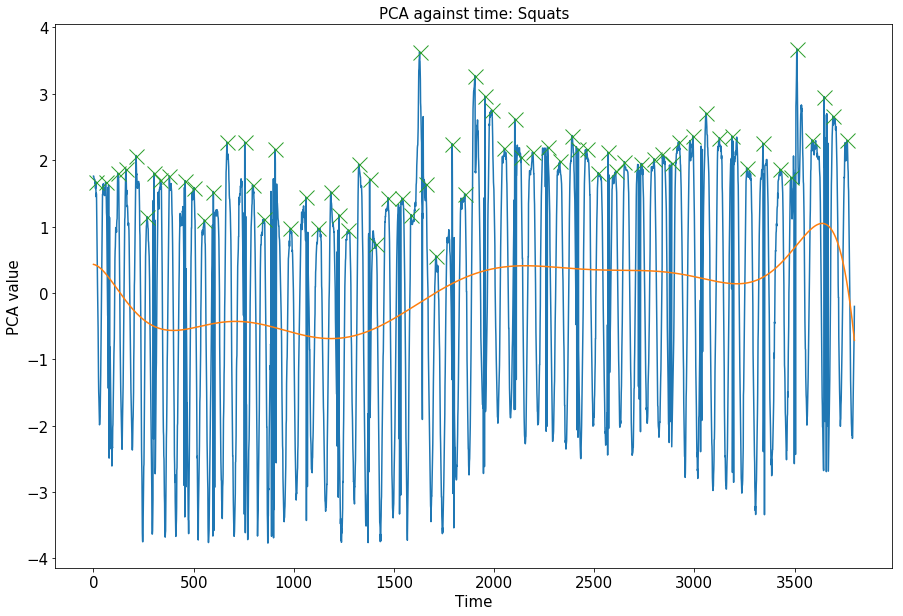

69


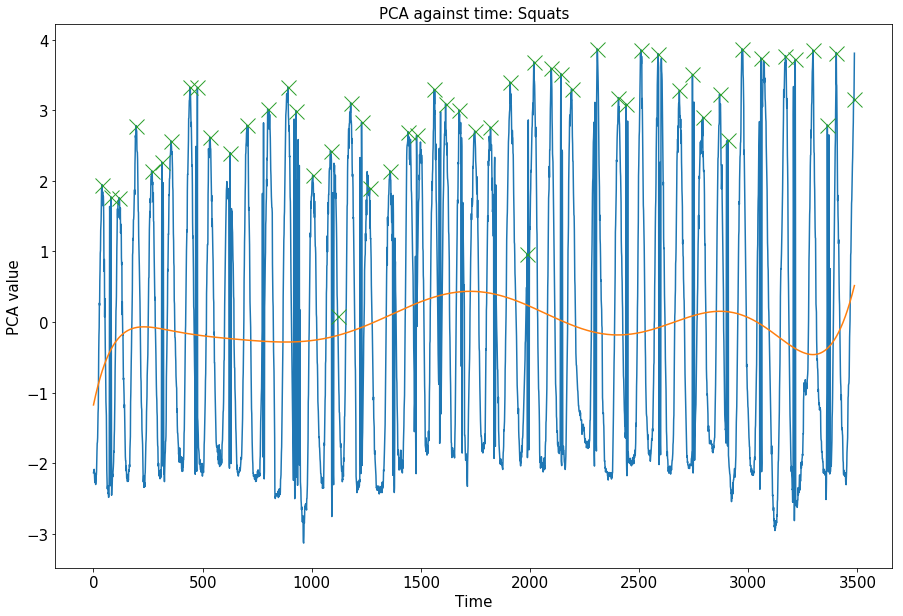

53


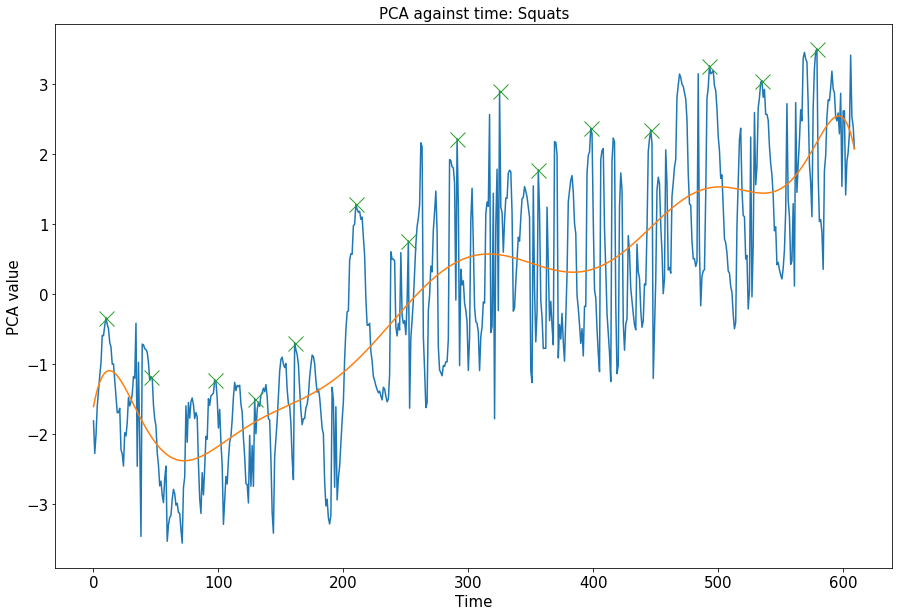

15


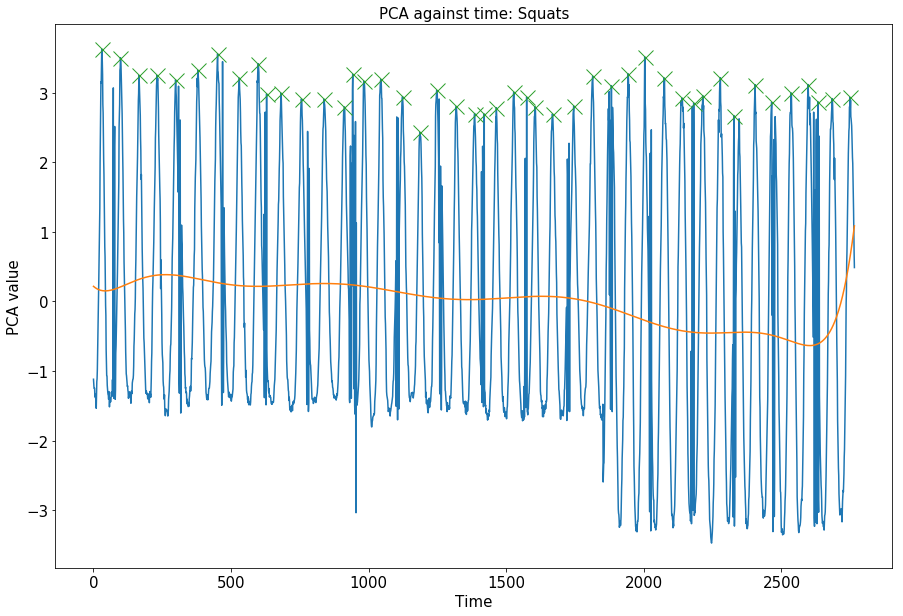

46


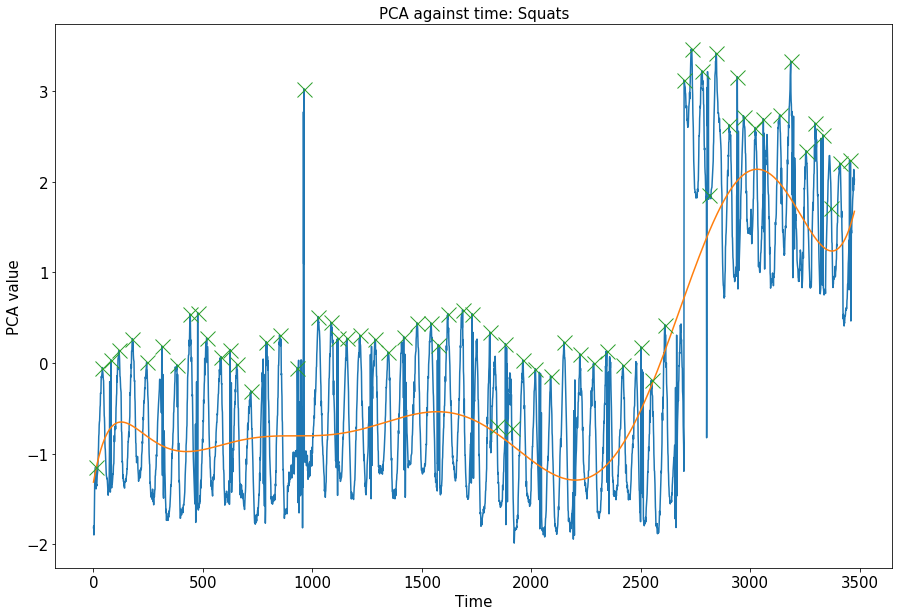

66


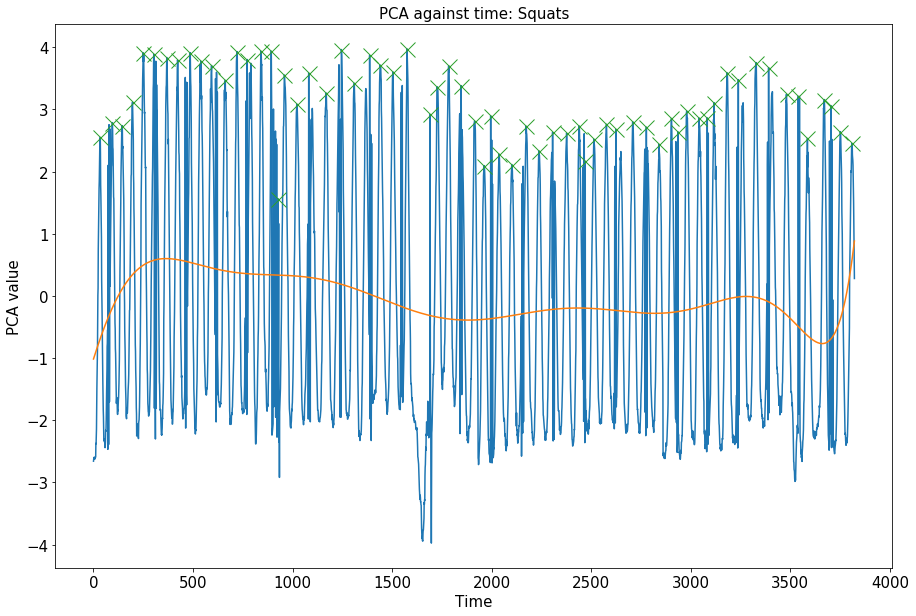

65


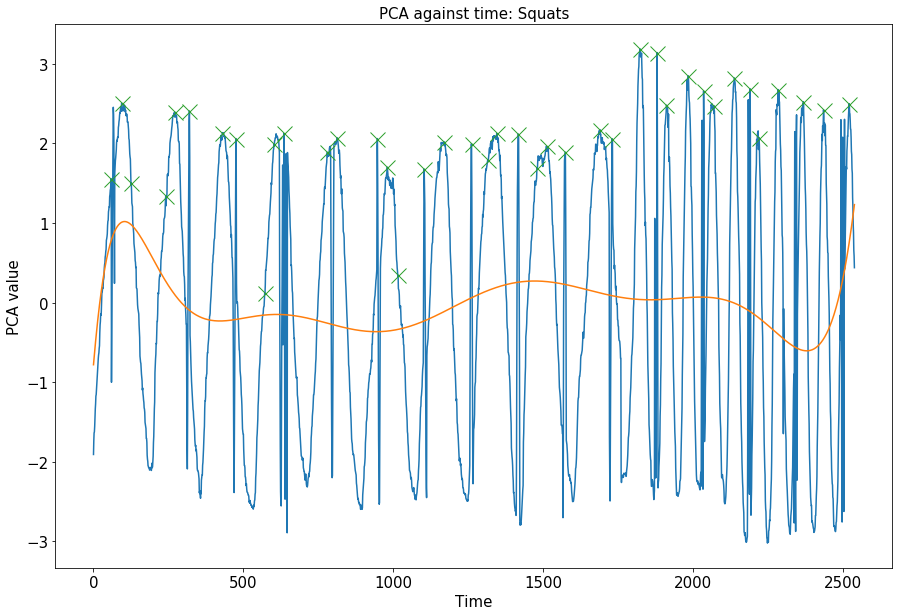

40


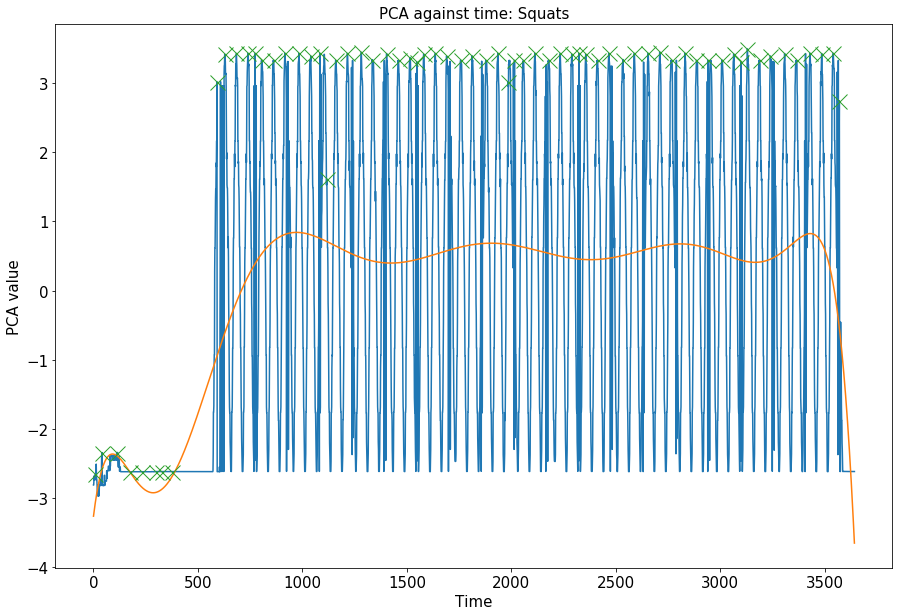

66


In [107]:
pcaAnalysis(squats0, length0)

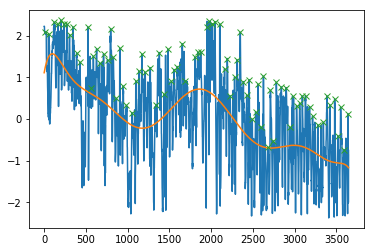

array([   9,   52,  122,  164,  201,  236,  270,  304,  343,  389,  429,
        523,  558,  589,  628,  664,  711,  759,  796,  826,  864,  908,
        947,  985, 1051, 1097, 1134, 1172, 1209, 1271, 1340, 1379, 1434,
       1483, 1524, 1555, 1595, 1655, 1692, 1809, 1843, 1875, 1948, 1978,
       2015, 2046, 2106, 2160, 2193, 2228, 2280, 2312, 2349, 2386, 2425,
       2456, 2492, 2532, 2563, 2594, 2626, 2678, 2710, 2745, 2781, 2841,
       2899, 2942, 2974, 3022, 3059, 3092, 3130, 3178, 3214, 3277, 3344,
       3388, 3422, 3479, 3516, 3550, 3593, 3639])

In [22]:
pcaAnalysis(chest0, length1)

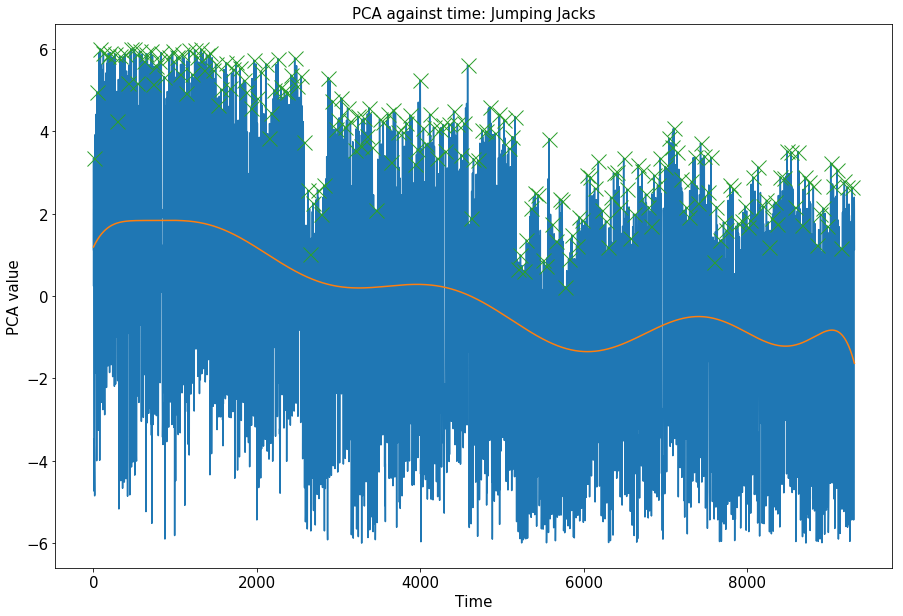

224


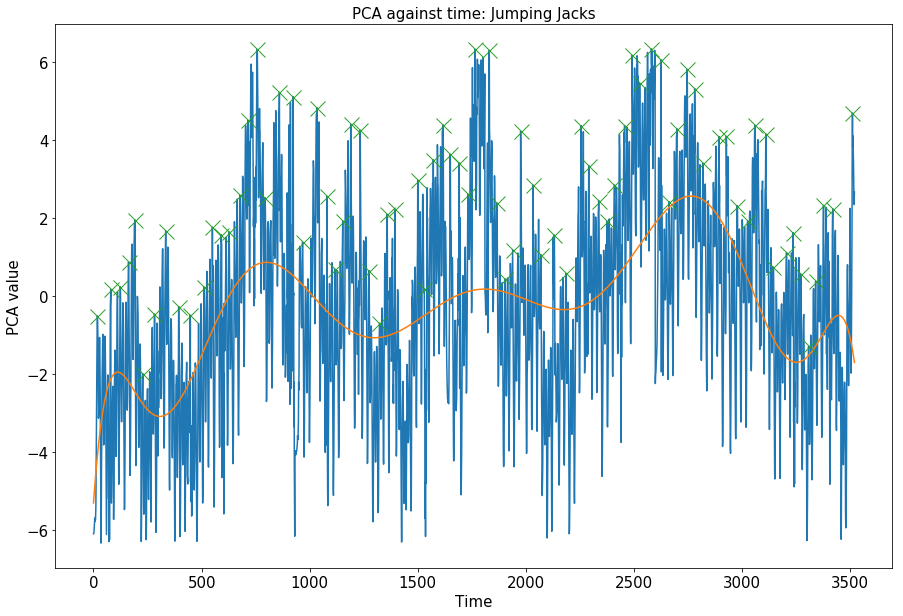

78


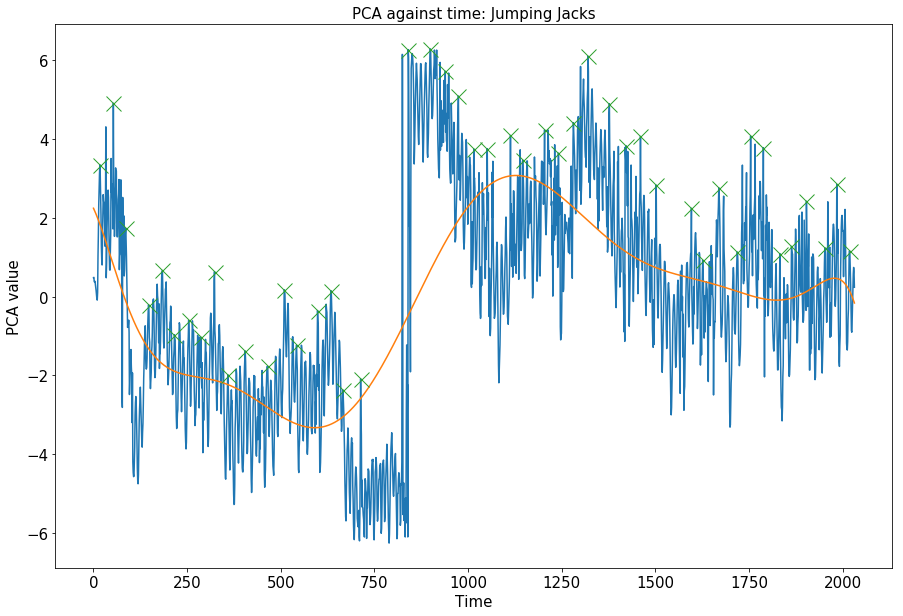

46


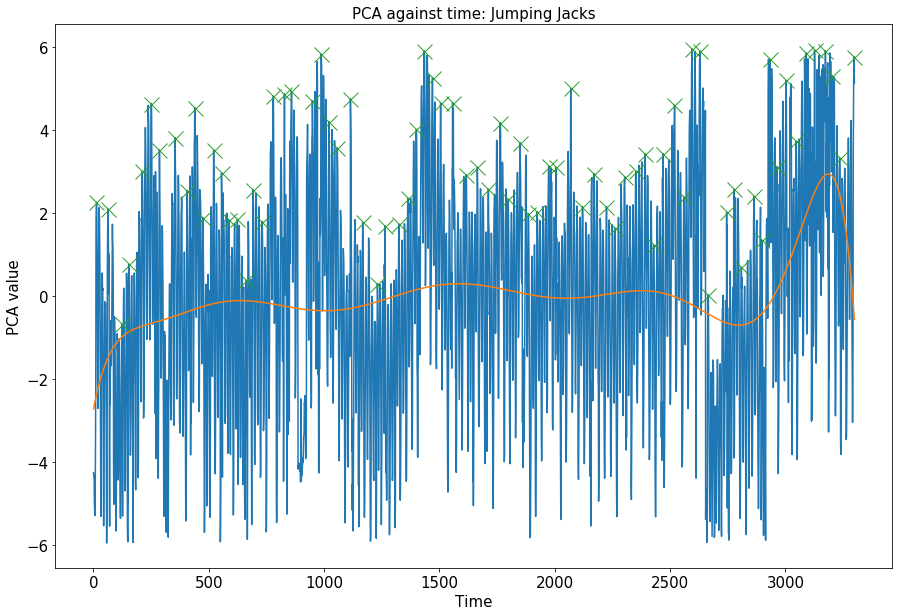

76


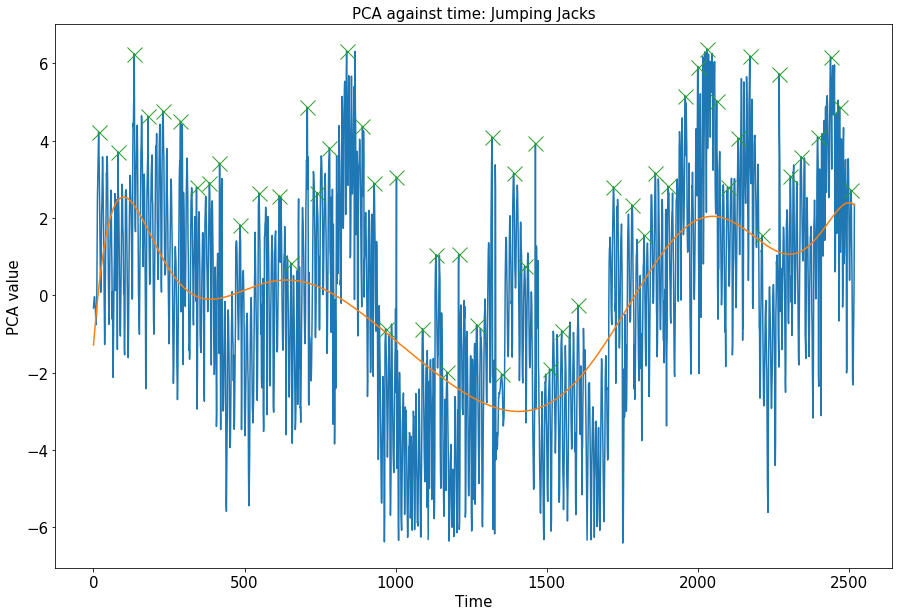

54


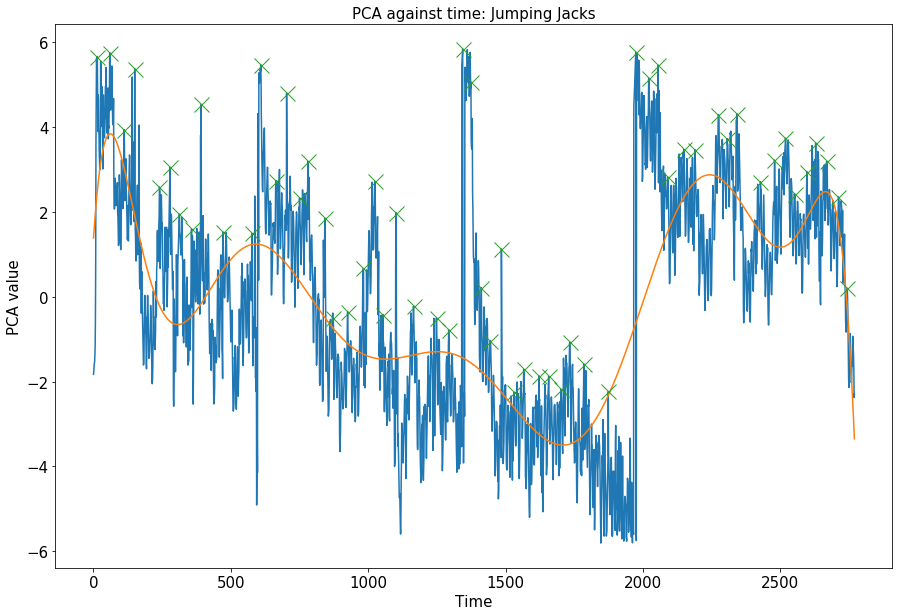

57


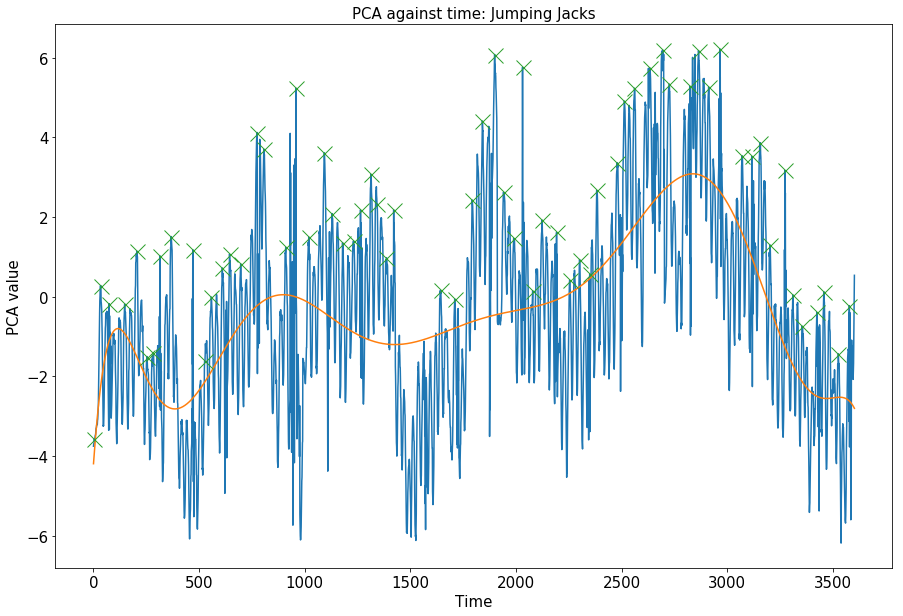

65


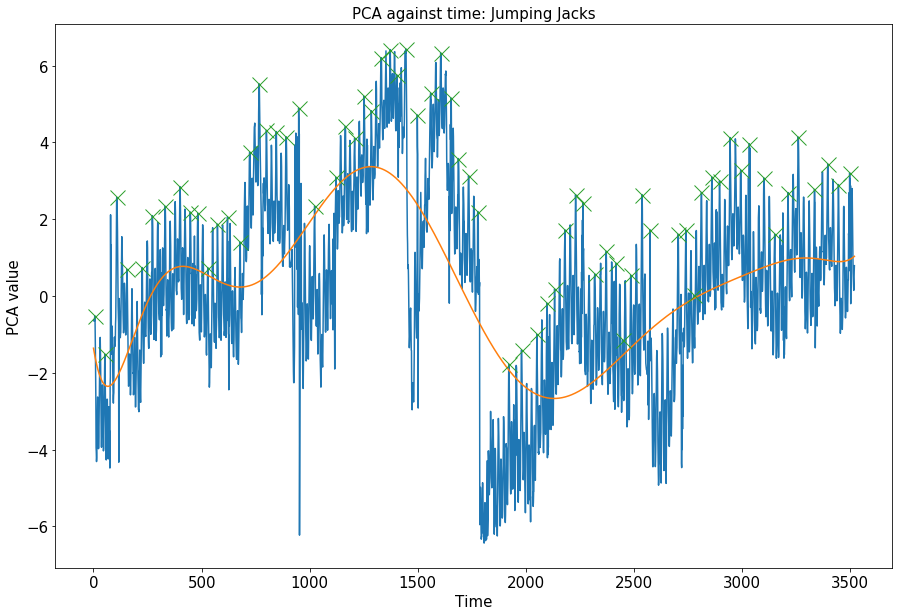

69


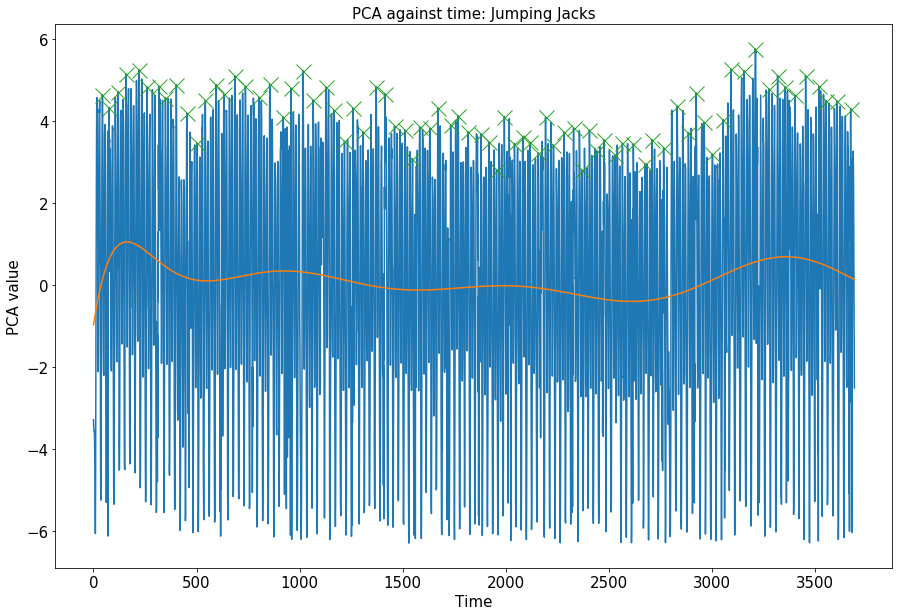

78


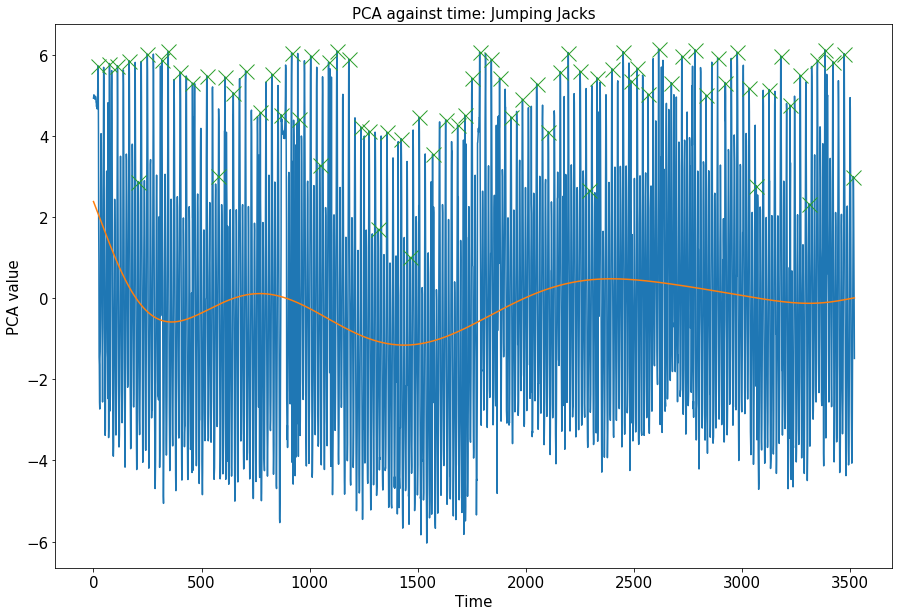

74


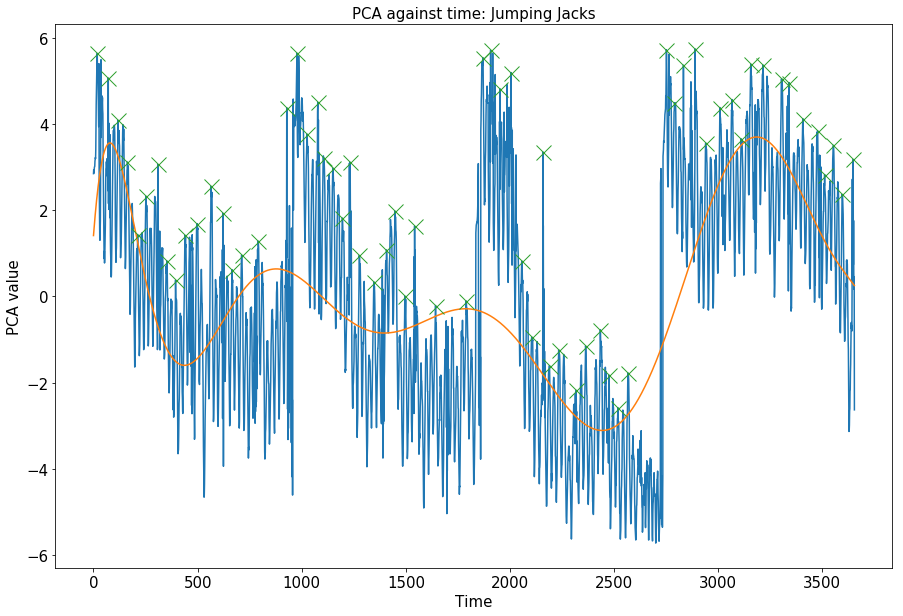

65


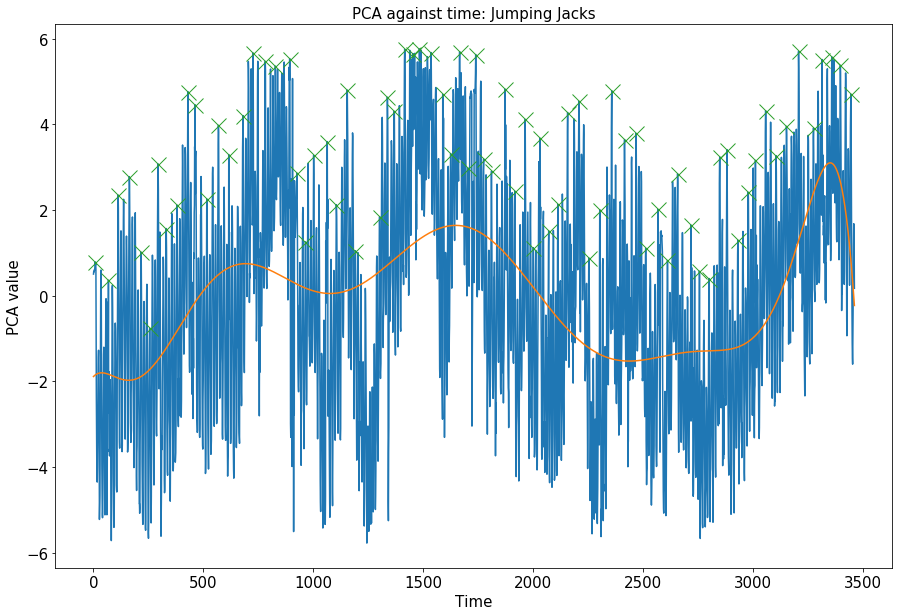

75


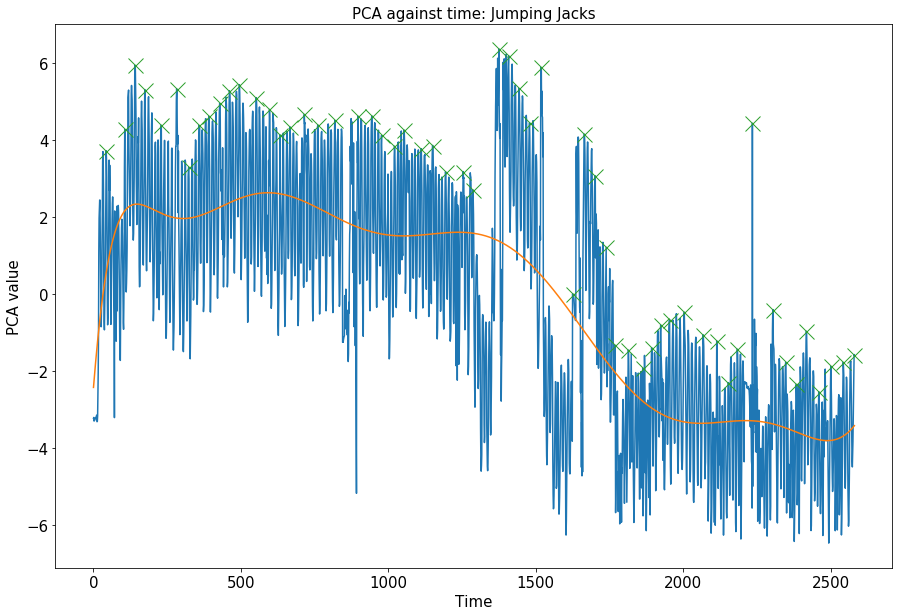

58


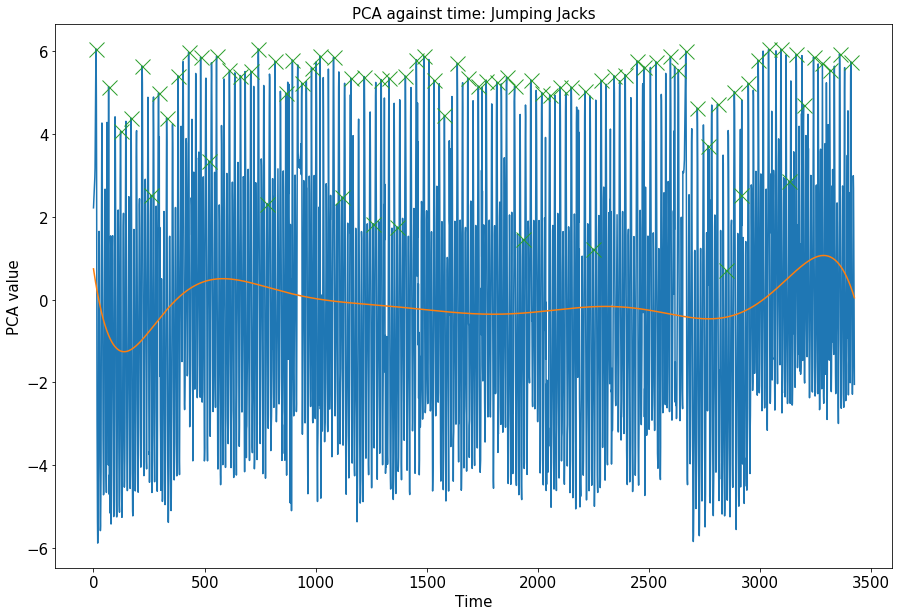

79


In [109]:
pcaAnalysis(starJump0, length2)

In [23]:
pcaAnalysis(punch0, length3)

Punches1
72
Punches10
63
Punches11
37
Punches12
86
Punches13
55
Punches2
94
Punches3
77
Punches4
89
Punches5
72
Punches6
67
Punches7
86
Punches8
77
Punches9
72


In [24]:
pcaAnalysis(arms0, length4)

Bicep1
151
Bicep10
31
Bicep11
77
Bicep12
36
Bicep13
78
Bicep14
57
Bicep15
82
Bicep3
77
Bicep4
38
Bicep5
61
Bicep6
85
Bicep7
87
Bicep8
78
Bicep9
33


squats_rescale = rescaleIndividually(squats0)
arms_rescale = rescaleIndividually(arms0)
starJump_rescale = rescaleIndividually(starJump0)
chest_rescale = rescaleIndividually(chest0)
punch_rescale = rescaleIndividually(punch0)

In [25]:
# pprint(chest_rescale[0]['LWrist'])

countRepetition('Squats', squats_rescale)